#### https://www.kaggle.com/code/dronax/car-prices-dataset#Residual-analysis-of-the-model

In [142]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import SpectralClustering


In [143]:
data = pd.read_csv("CarPrice_Assignment.csv")
data = data.iloc[:, 1:]
data.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

# Cleaning Data

In [145]:
companyName = data["CarName"].apply(lambda x: x.split()[0])
carModel = data["CarName"].apply(lambda x: "".join(x.split()[1:]))

In [146]:
data.insert(3, "CompanyName", companyName)
data.insert(4, "CarModel", carModel)

In [147]:
data.drop("CarName", axis=1, inplace=True)
data.head()

,symboling,fueltype,CompanyName,CarModel,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,alfa-romero,giulia,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,alfa-romero,stelvio,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,alfa-romero,Quadrifoglio,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,audi,100ls,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,audi,100ls,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [148]:
data.columns

Index(['symboling', 'fueltype', 'CompanyName', 'CarModel', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [149]:
def get_variable_type(element):
    if element == 0:
        return "Not Known"
    elif element < 20 and element != 0:
        return "Categorical"
    elif element >= 20 and element != 0:
        return "Contineous"


def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Valeurs_Uniques_Count"].apply(
        get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - \
        metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix


def get_meta_data(dataframe):
    metadata_matrix = pd.DataFrame({
        'Datatype': dataframe.dtypes.astype(str),
        'Non_Null_Count': dataframe.count(axis=0).astype(int),
        'Null_Count': dataframe.isnull().sum().astype(int),
        'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100,
        'Valeurs_Uniques_Count': dataframe.nunique().astype(int)
    })

    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix


def list_potential_categorical_type(dataframe, data):
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"]
                                            == "Categorical"]

    length = len(metadata_matrix_categorical)
    if length == 0:
        print("There is not categorical column")
    else:
        metadata_matrix_categorical = metadata_matrix_categorical.filter(
            ["Datatype", "Valeurs_Uniques_Count"])
        metadata_matrix_categorical.sort_values(
            ["Valeurs_Uniques_Count"], axis=0, ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []

        for name in col_to_check:
            name_list.append(name)
            values_list.append(data[name].unique())

        temp = pd.DataFrame({
            "index": name_list,
            "Valeurs_Uniques": values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(
            metadata_matrix_categorical, temp, how='inner', on='index')
        display(metadata_matrix_categorical.set_index("index"))


In [150]:
metadata = get_meta_data(data)
metadata

,Datatype,Non_Null_Count,Null_Count,Null_Percentage,Valeurs_Uniques_Count,Variable_Type,frequency
symboling,int64,205,0,0.0,6,Categorical,0
fueltype,object,205,0,0.0,2,Categorical,0
CompanyName,object,205,0,0.0,28,Contineous,0
CarModel,object,205,0,0.0,141,Contineous,0
aspiration,object,205,0,0.0,2,Categorical,0
doornumber,object,205,0,0.0,2,Categorical,0
carbody,object,205,0,0.0,5,Categorical,0
drivewheel,object,205,0,0.0,3,Categorical,0
enginelocation,object,205,0,0.0,2,Categorical,0
wheelbase,float64,205,0,0.0,53,Contineous,0


In [151]:
potential_categoric = list_potential_categorical_type(metadata, data)
potential_categoric

,Datatype,Valeurs_Uniques_Count,Valeurs_Uniques
index,,,
fuelsystem,object,8,"[mpfi, 2bbl, mfi, 1bbl, spfi, 4bbl, idi, spdi]"
enginetype,object,7,"[dohc, ohcv, ohc, l, rotor, ohcf, dohcv]"
cylindernumber,object,7,"[four, six, five, three, twelve, two, eight]"
symboling,int64,6,"[3, 1, 2, 0, -1, -2]"
carbody,object,5,"[convertible, hatchback, sedan, wagon, hardtop]"
drivewheel,object,3,"[rwd, fwd, 4wd]"
fueltype,object,2,"[gas, diesel]"
aspiration,object,2,"[std, turbo]"
doornumber,object,2,"[two, four]"


In [152]:
data = data.replace(to_replace ="maxda", value ="mazda") 
data = data.replace(to_replace ="porcshce", value ="porsche") 
data = data.replace(to_replace ="toyouta", value ="toyota") 
data = data.replace(to_replace ="vokswagen", value ="volkswagen") 
data = data.replace(to_replace ="vw", value ="volkswagen")
data = data.replace(to_replace ="Nissan", value ="nissan")

In [153]:
data.CompanyName.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

# Visualization

count      205.000000
mean     13276.710571
std       7988.852332
min       5118.000000
25%       7788.000000
50%      10295.000000
75%      16503.000000
max      45400.000000
Name: price, dtype: float64


<AxesSubplot:title={'center':'Car Price Spread'}, ylabel='price'>

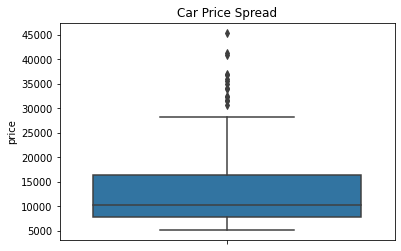

In [154]:
print(data["price"].describe())

plt.title("Car Price Spread")
sns.boxplot(y = data["price"])

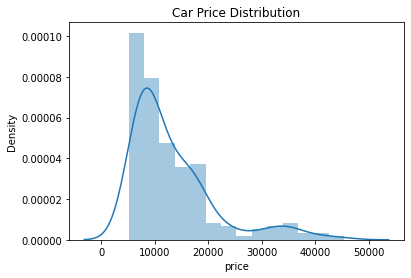

In [155]:
plt.title("Car Price Distribution")
sns.distplot(data["price"]);


# Visualization of independent variables:
# Numericals

In [156]:
import scipy
from scipy.stats.stats import pearsonr


def pairplot(x_axis, y_axis):
    sns.pairplot(data, x_vars=x_axis, y_vars=y_axis,
                 height=4, aspect=1, kind="scatter")

    plt.show()


In [157]:
y_vars = ["price"]

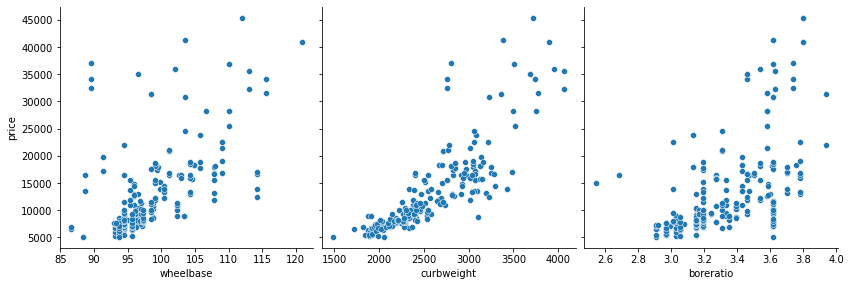

At first glance, the 3 variables are positively correlated but spread at higher values.
Correlation between price ana whellbase: % 57.78155982921503
Correlation between price ana curbweight: % 83.53048793372967
Correlation between price ana boreratio: % 55.317323679844364


In [158]:
x_vars = ['wheelbase', 'curbweight', 'boreratio']
pairplot(x_vars, y_vars)
print("At first glance, the 3 variables are positively correlated but spread at higher values.")

p1 = data['wheelbase']
p2 = data['curbweight']
p3 = data['boreratio']

pearson_coeff, p_value = pearsonr(p1, data["price"])
print("Correlation between price ana whellbase: %", pearson_coeff * 100)

pearson_coeff, p_value = pearsonr(p2, data["price"])
print("Correlation between price ana curbweight: %", pearson_coeff * 100)

pearson_coeff, p_value = pearsonr(p3, data["price"])
print("Correlation between price ana boreratio: %", pearson_coeff * 100)


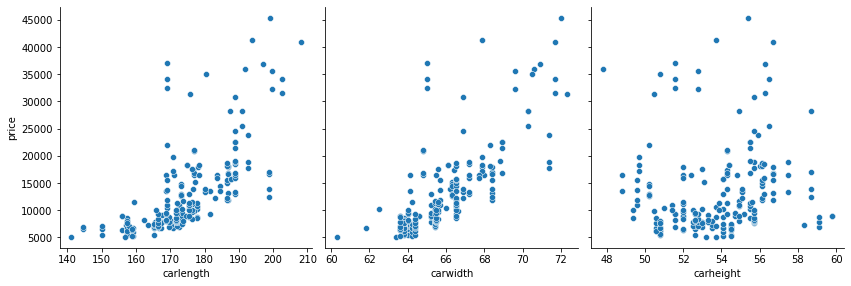

Carlength and Carwidth are more correlated than carheight which is more spread out but positive.
Correlation between price ana carlength: % 68.2920015677962
Correlation between price ana carwidth: % 75.93252997415115
Correlation between price ana carheight: % 11.933622657049447


In [159]:
x_vars = ["carlength", "carwidth", "carheight"]
pairplot(x_vars, y_vars)
print("Carlength and Carwidth are more correlated than carheight which is more spread out but positive.")

p1 = data['carlength']
p2 = data['carwidth']
p3 = data['carheight']

pearson_coeff, p_value = pearsonr(p1, data["price"])
print("Correlation between price ana carlength: %", pearson_coeff * 100)

pearson_coeff, p_value = pearsonr(p2, data["price"])
print("Correlation between price ana carwidth: %", pearson_coeff * 100)

pearson_coeff, p_value = pearsonr(p3, data["price"])
print("Correlation between price ana carheight: %", pearson_coeff * 100)


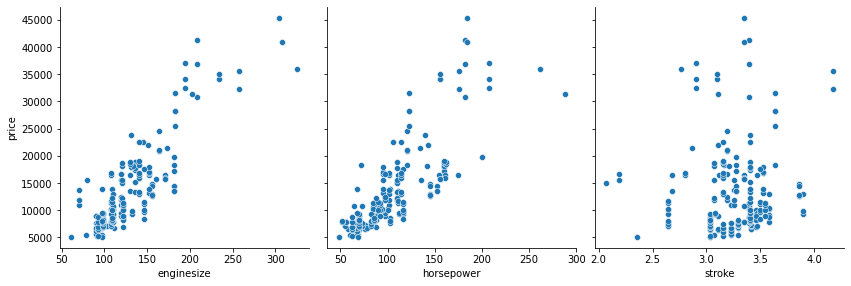

Enginesize and Horsepower are positively correlated, but Stroke is more spread out (may not be related).
Correlation between price ana enginesize: % 87.41448025245117
Correlation between price ana horsepower: % 80.81388225362215
Correlation between price ana stroke: % 7.9443083881931


In [160]:
x_vars = ["enginesize", "horsepower", "stroke"]
pairplot(x_vars, y_vars)
print("Enginesize and Horsepower are positively correlated, but Stroke is more spread out (may not be related).")

p1 = data['enginesize']
p2 = data['horsepower']
p3 = data['stroke']

pearson_coeff, p_value = pearsonr(p1, data["price"])
print("Correlation between price ana enginesize: %", pearson_coeff * 100)

pearson_coeff, p_value = pearsonr(p2, data["price"])
print("Correlation between price ana horsepower: %", pearson_coeff * 100)

pearson_coeff, p_value = pearsonr(p3, data["price"])
print("Correlation between price ana stroke: %", pearson_coeff * 100)


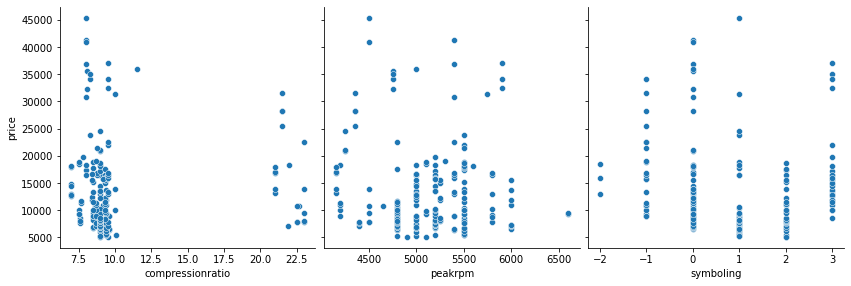

Compressionratio, Peakrpm and symboling are not correlated.
Correlation between price ana compressionratio: % 6.798350579944261
Correlation between price ana peakrpm: % -8.526715027785686
Correlation between price ana symboling: % -7.997822464270349


In [161]:
x_vars = ["compressionratio", "peakrpm", "symboling"]
pairplot(x_vars, y_vars)
print("Compressionratio, Peakrpm and symboling are not correlated.")

p1 = data['compressionratio']
p2 = data['peakrpm']
p3 = data['symboling']

pearson_coeff, p_value = pearsonr(p1, data["price"])
print("Correlation between price ana compressionratio: %", pearson_coeff * 100)

pearson_coeff, p_value = pearsonr(p2, data["price"])
print("Correlation between price ana peakrpm: %", pearson_coeff * 100)

pearson_coeff, p_value = pearsonr(p3, data["price"])
print("Correlation between price ana symboling: %", pearson_coeff * 100)


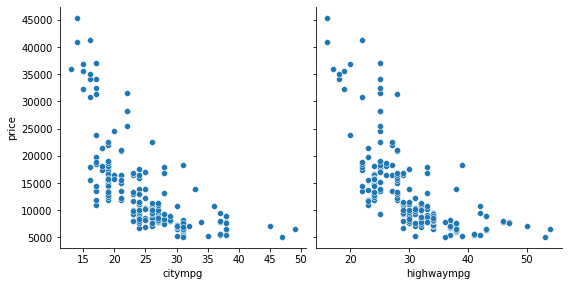

Citympg & Highwaympg are negatively correlated.
The more prices get lower, the higher the distances get, which means that the cheapest cars have better mileage than expensive cars.
Correlation between price ana citympg: % -68.575133602704
Correlation between price ana highwaympg: % -69.75990916465562


In [162]:
x_vars = ['citympg', 'highwaympg']
pairplot(x_vars, y_vars)
print('Citympg & Highwaympg are negatively correlated.\nThe more prices get lower, the higher the distances get, which means that the cheapest cars have better mileage than expensive cars.')

p1 = data['citympg']
p2 = data['highwaympg']

pearson_coeff, p_value = pearsonr(p1, data["price"])
print("Correlation between price ana citympg: %", pearson_coeff * 100)

pearson_coeff, p_value = pearsonr(p2, data["price"])
print("Correlation between price ana highwaympg: %", pearson_coeff * 100)


Conclusion

(+) positively correlated variables 
with Price: wheelbase, carlenght, carwidth, curbweight, enginesize, boreratio, horesepower

(-) negatively correlated variables
 with Price: citympg, highwaympg

In [163]:
data.columns

Index(['symboling', 'fueltype', 'CompanyName', 'CarModel', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [164]:
def heatmap(df):

    sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
    plt.show()


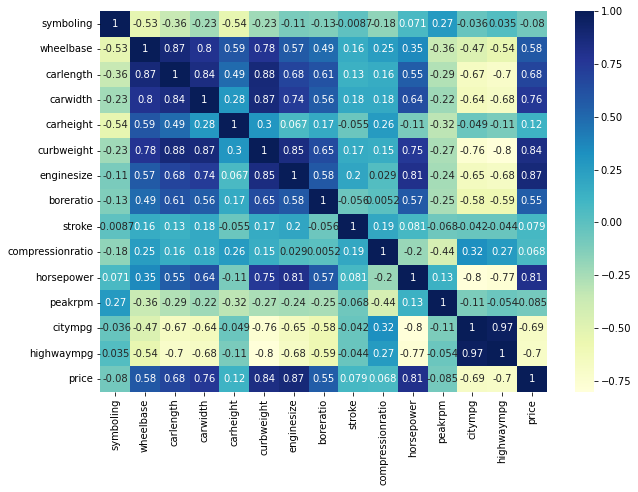

In [165]:
plt.figure(figsize=(10,7))
heatmap(data)

## a. Examination of the correlation between the variables specific to the dimensions of a car i.e. weight, height etc

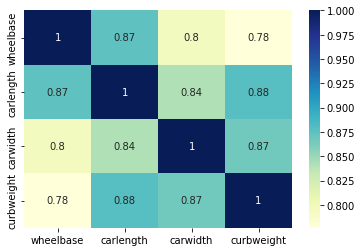

In [166]:
dimension_col_list = ['wheelbase', 'carlength', 'carwidth','curbweight']

# heatmap(data.filter(dimension_col_list))
heatmap(data[dimension_col_list])

Wheelbase , carlength, carwidth et curbweight [ 0.80 - 0.88 ] are very correlated and we have to keep only one between them.

## b. Examination of the correlation between the variables specific to the performance of a car



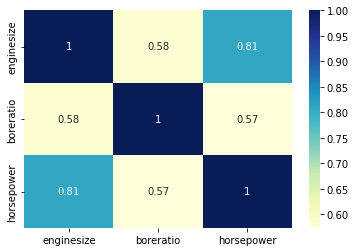

In [167]:
performance_col_list = ['enginesize','boreratio','horsepower']
heatmap(data[performance_col_list])

Horsepower and enginesize are highly correlated and we need to keep only one.



## c. Examining the correlation between citympg and highwaympg



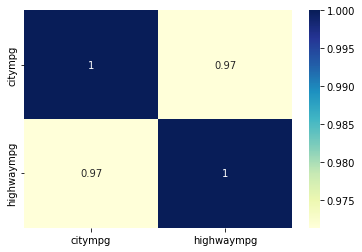

In [168]:
performance_col_list = ['citympg','highwaympg']
heatmap(data[performance_col_list])

citympg and highwaympg are highly correlated and we need to keep one of them.



# Categorical 

Price VS CompanyName



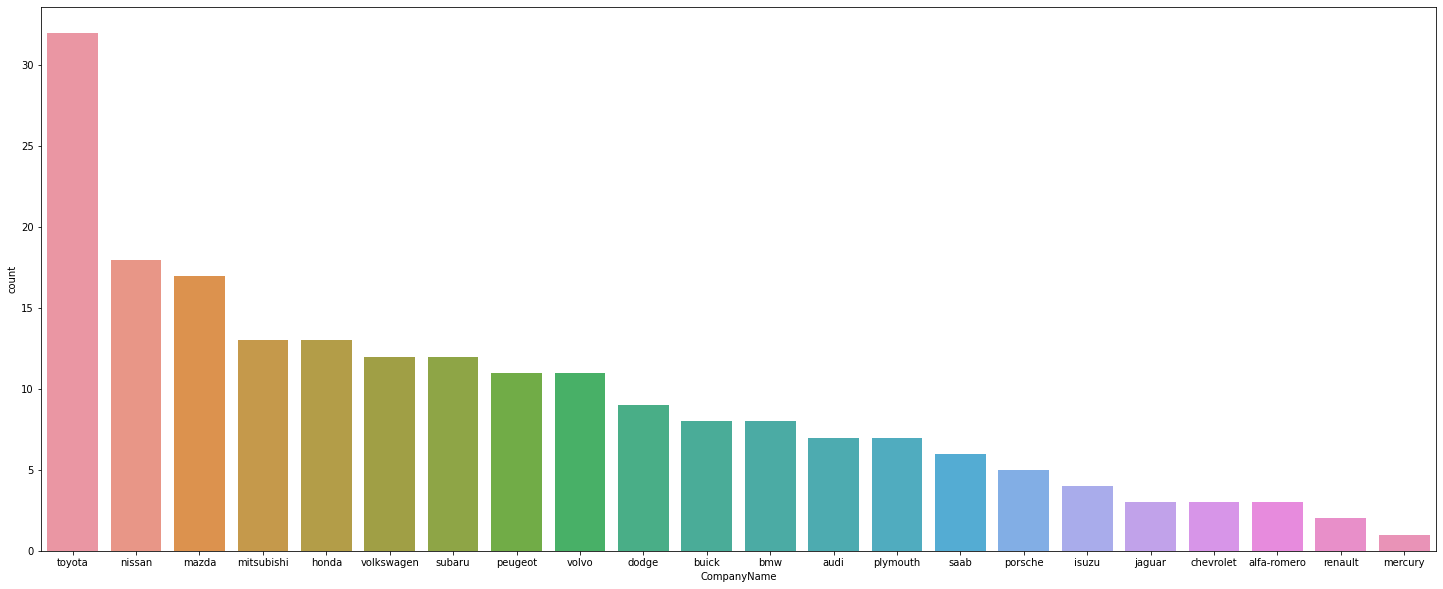

In [169]:
plt.figure(figsize=(25, 10))
order = data["CompanyName"].value_counts(ascending=False).index
sns.countplot(x = "CompanyName", data = data, order = order);

Price VS fueltype



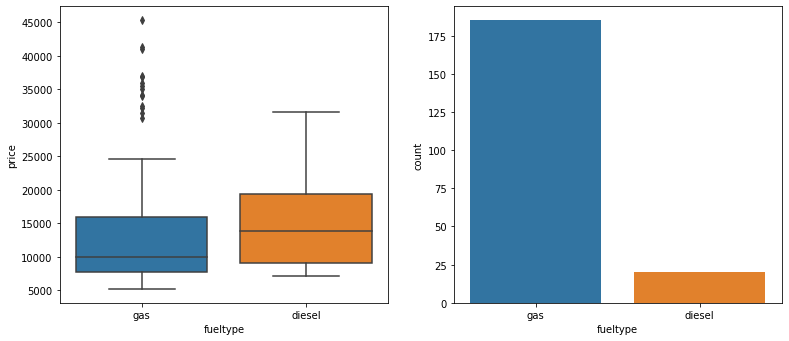

In [170]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
sns.boxplot(x = "fueltype", y = "price", data = data);

plt.subplot(2, 3, 2)
order = data["fueltype"].value_counts(ascending=False).index
sns.countplot(x = "fueltype", data = data, order = order);

Price VS aspiration



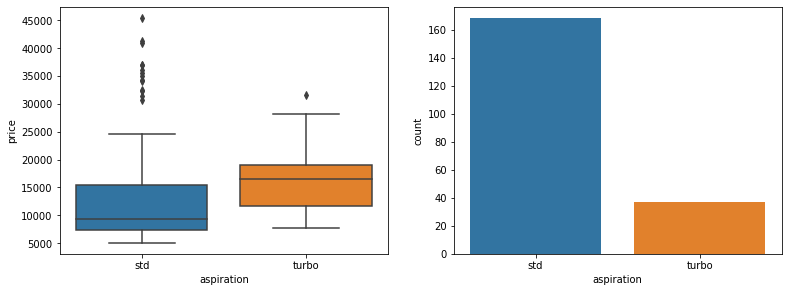

In [171]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
sns.boxplot(x = "aspiration", y = "price", data = data)

plt.subplot(2, 3, 2)
order = data["aspiration"].value_counts(ascending=False).index
sns.countplot(x = "aspiration", data = data, order = order);


Price VS doornumber



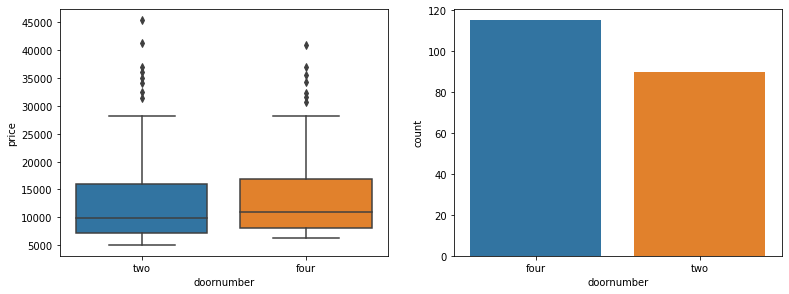

In [172]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
sns.boxplot(x = "doornumber", y = "price", data = data)

plt.subplot(2, 3, 2)
order = data["doornumber"].value_counts(ascending=False).index
sns.countplot(x = "doornumber", data = data, order = order);

Price VS enginelocation



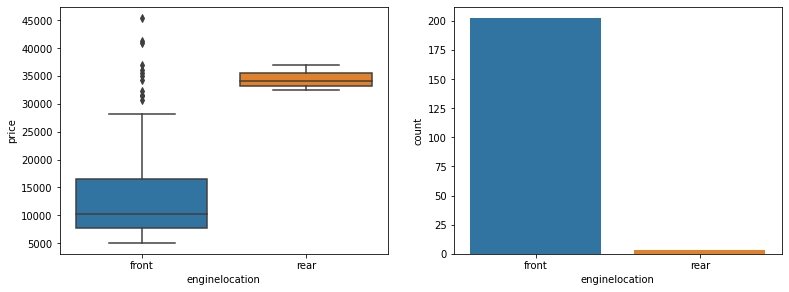

In [173]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
sns.boxplot(x = "enginelocation", y = "price", data = data)

plt.subplot(2, 3, 2)
order = data["enginelocation"].value_counts(ascending=False).index
sns.countplot(x = "enginelocation", data = data, order = order);

Price VS carbody



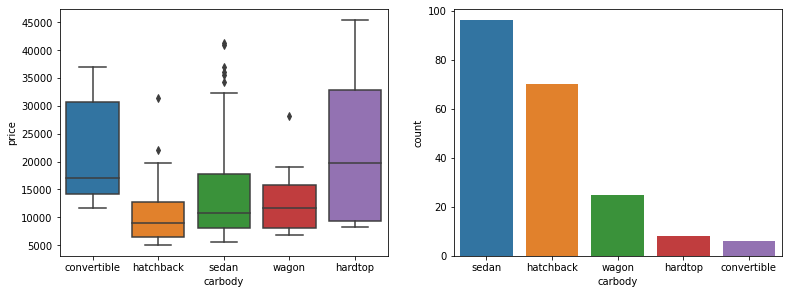

In [174]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
sns.boxplot(x = "carbody", y = "price", data = data)

plt.subplot(2, 3, 2)
order = data["carbody"].value_counts(ascending=False).index
sns.countplot(x = "carbody", data = data, order = order);

# convertible = üstü açılabilen araba
# hatchback = arkada kapısı olan küçük araba
# hardtop = üstü kapalı araç

Price VS fuelsystem



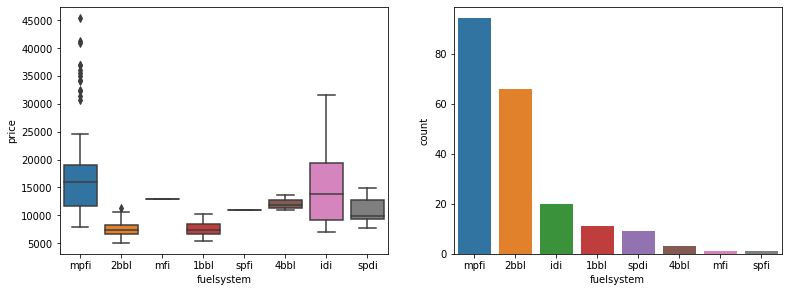

In [175]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
sns.boxplot(x = "fuelsystem", y = "price", data = data)

plt.subplot(2, 3, 2)
order = data["fuelsystem"].value_counts(ascending=False).index
sns.countplot(x = "fuelsystem", data = data, order = order);


Price VS enginetype



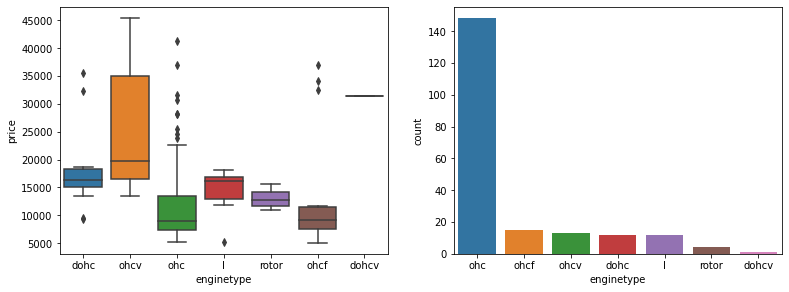

In [176]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
sns.boxplot(x = "enginetype", y = "price", data = data)

plt.subplot(2, 3, 2)
order = data["enginetype"].value_counts(ascending=False).index
sns.countplot(x = "enginetype", data = data, order = order);


Price VS cylindernumber



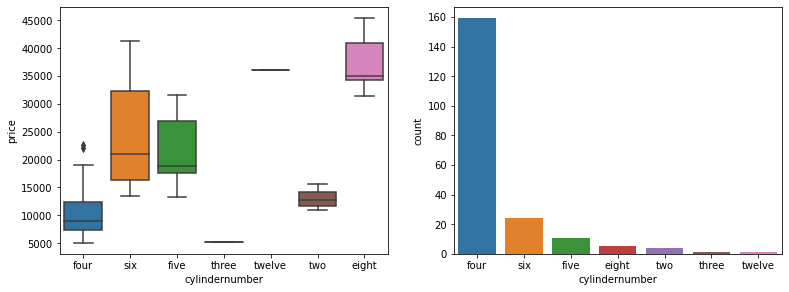

In [177]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
sns.boxplot(x = "cylindernumber", y = "price", data = data)

plt.subplot(2, 3, 2)
order = data["cylindernumber"].value_counts(ascending=False).index
sns.countplot(x = "cylindernumber", data = data, order = order);


Price VS drivewheel



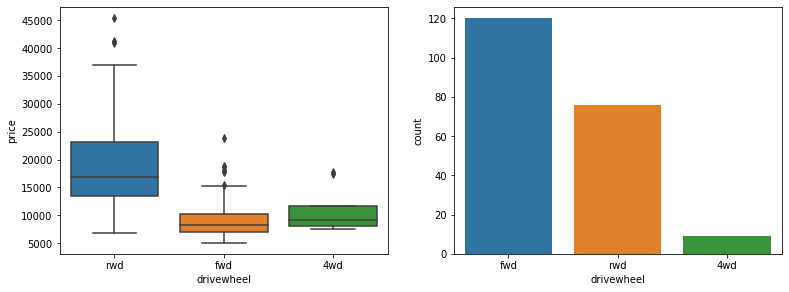

In [178]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
sns.boxplot(x = "drivewheel", y = "price", data = data)

plt.subplot(2, 3, 2)
order = data["drivewheel"].value_counts(ascending=False).index
sns.countplot(x = "drivewheel", data = data, order = order);


Price VS symboling



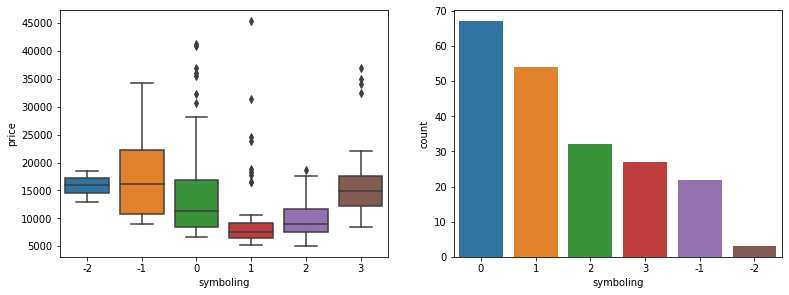

In [179]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
sns.boxplot(x = "symboling", y = "price", data = data)

plt.subplot(2, 3, 2)
order = data["symboling"].value_counts(ascending=False).index
sns.countplot(x = "symboling", data = data, order = order);


# Data preparation

In [180]:
metadata_df = get_meta_data(data)
list_potential_categorical_type(metadata_df, data)

,Datatype,Valeurs_Uniques_Count,Valeurs_Uniques
index,,,
fuelsystem,object,8,"[mpfi, 2bbl, mfi, 1bbl, spfi, 4bbl, idi, spdi]"
enginetype,object,7,"[dohc, ohcv, ohc, l, rotor, ohcf, dohcv]"
cylindernumber,object,7,"[four, six, five, three, twelve, two, eight]"
symboling,int64,6,"[3, 1, 2, 0, -1, -2]"
carbody,object,5,"[convertible, hatchback, sedan, wagon, hardtop]"
drivewheel,object,3,"[rwd, fwd, 4wd]"
fueltype,object,2,"[gas, diesel]"
aspiration,object,2,"[std, turbo]"
doornumber,object,2,"[two, four]"


Remove the uncorrelated variables with Price, and choose only one variable among the variables correlated with it



In [181]:
data2 = data.drop(['carheight', 'stroke', 'compressionratio', 'peakrpm',
                  'carlength', 'carwidth', 'curbweight', 'enginesize', 'highwaympg'], axis= 1)
data2.head()

,symboling,fueltype,CompanyName,CarModel,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,enginetype,cylindernumber,fuelsystem,boreratio,horsepower,citympg,price
0,3,gas,alfa-romero,giulia,std,two,convertible,rwd,front,88.6,dohc,four,mpfi,3.47,111,21,13495.0
1,3,gas,alfa-romero,stelvio,std,two,convertible,rwd,front,88.6,dohc,four,mpfi,3.47,111,21,16500.0
2,1,gas,alfa-romero,Quadrifoglio,std,two,hatchback,rwd,front,94.5,ohcv,six,mpfi,2.68,154,19,16500.0
3,2,gas,audi,100ls,std,four,sedan,fwd,front,99.8,ohc,four,mpfi,3.19,102,24,13950.0
4,2,gas,audi,100ls,std,four,sedan,4wd,front,99.4,ohc,five,mpfi,3.19,115,18,17450.0


Dummy Variables creation

In [182]:
# def binary_dummy_replace(x):
#     return x.map({"gas": 1, "diesel": 0,
#                   "std": 1, "turbo": 0,
#                   "two": 1, "four": 0,
#                   "front": 1, "rear": 0})


def dummies(x, df):
    temp = pd.get_dummies(df[x], prefix=x, drop_first=True)

    df = pd.concat([df, temp], axis=1)
    df.drop([x], axis=1, inplace=True)
    return df


In [183]:
data2 = dummies('symboling', data)
data2 = dummies('CompanyName', data2)
data2 = dummies('fueltype', data2)
data2 = dummies('aspiration', data2)
data2 = dummies('doornumber', data2)
data2 = dummies('carbody', data2)
data2 = dummies('drivewheel', data2)
data2 = dummies('enginelocation', data2)
data2 = dummies('enginetype', data2)
data2 = dummies('cylindernumber', data2)
data2 = dummies('fuelsystem', data2)


In [184]:
data2.head()

,CarModel,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,giulia,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,0,0,0,0,0,0,0,1,0,0
1,stelvio,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,0,0,0,0,0,0,0,1,0,0
2,Quadrifoglio,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,...,0,0,0,0,0,0,0,1,0,0
3,100ls,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,...,0,0,0,0,0,0,0,1,0,0
4,100ls,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,...,0,0,0,0,0,0,0,1,0,0


In [185]:
data2 = data2[['wheelbase','boreratio','horsepower','citympg','price',] + list(data2.columns[15:])]
data2.head()

,wheelbase,boreratio,horsepower,citympg,price,symboling_-1,symboling_0,symboling_1,symboling_2,symboling_3,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,88.6,3.47,111,21,13495.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,88.6,3.47,111,21,16500.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,94.5,2.68,154,19,16500.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,99.8,3.19,102,24,13950.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,99.4,3.19,115,18,17450.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# Preparation of Train and Test data



In [186]:
from sklearn.model_selection import train_test_split

cars_train, cars_test = train_test_split(
    data2, train_size=0.67, test_size=0.33, random_state=0)


# Feature Scaling: Train Set & Test Set



In [187]:
from sklearn.preprocessing import StandardScaler,scale
sc = StandardScaler() 

col_to_scale = ['wheelbase','boreratio','horsepower','citympg','price',]

cars_train[col_to_scale] = sc.fit_transform(cars_train[col_to_scale])
cars_test[col_to_scale] = sc.fit_transform(cars_test[col_to_scale])


Division into X_train and y_train sets for model construction



In [188]:
X_train = cars_train.loc[:, cars_train.columns != "price"]
y_train = cars_train.loc[:, cars_train.columns == "price"]

Division into X_test and y_test sets



In [189]:
X_test = cars_test.loc[:, cars_test.columns != "price"]
y_test = cars_test.loc[:, cars_test.columns == "price"]

# Prediction and Evaluation

## 1. Prediction

Now let's use our model to make predictions.

In [190]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)


## 2. Evaluation

**Residual analysis of the model**

Residuals (i.e. errors) are simply the difference between predictions and observations

In [191]:
resid = y_test - y_pred.to_frame("price")

## 2-A. Normality of the error distribution



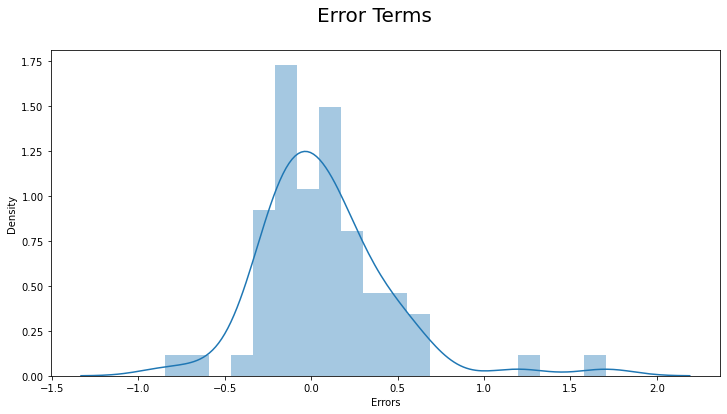

In [192]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(resid, bins=20)

fig.suptitle("Error Terms", fontsize=20)
plt.xlabel("Errors")
plt.show()

Analysis: The error terms are distributed around zero, which means that the prediction of the model is not random.



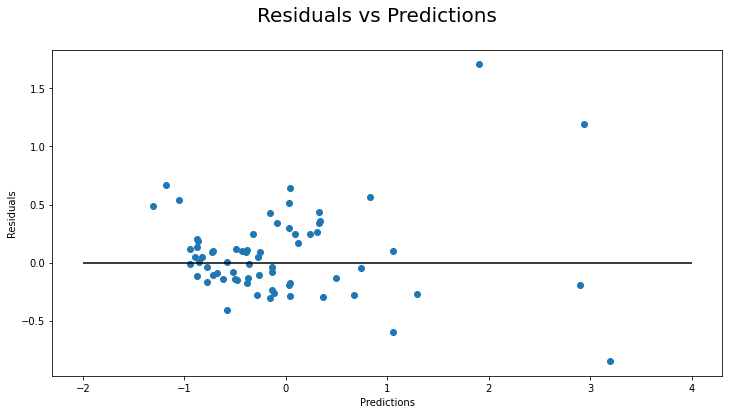

In [193]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(y_pred, resid)
plt.hlines(0, -2, 4, color="black")

fig.suptitle("Residuals vs Predictions", fontsize=20)
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.show()

Analysis: We can see that the values are evenly distributed around 0, with only a few outliers .



## Anderson-Darling Test and Q-Q Plot of residuals



Q-Q Plot:
An arc-shaped deflection trace with respect to the diagonal implies that the residuals have an excessive asymmetry, meaning that the distribution is not symmetrical, with too many important residuals in one direction.

Anderson-Darling Test
Remains the most used by experts, to check the standard of errors.

It tests:

H0: Data follow normal distribution

H1: Data does not follow normal distribution

How to check H0?

A level of significance is chosen by us (5% in our case), which is associated with a critical value.

If the returned A-D statistic is greater than the critical value for the chosen significance level, then H0 must be rejected.

Anderson-Darling test 
Statistic: 0.5530, Critical value of 5%: 0.7660


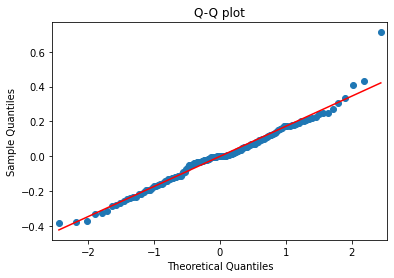

In [194]:
from scipy import stats


def normality_of_residuals_test(model):
    '''
    Function to establish the normal QQ graph of the residues and perform the Anderson-Darming statistical test to study the normality of the residuals.

    Arg:
    * model - OLS models adapted from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s')
    plt.title('Q-Q plot')

    ad = stats.anderson(model.resid, dist='norm')

    print(f'Anderson-Darling test \nStatistic: {ad.statistic:.4f}, Critical value of 5%: {ad.critical_values[2]:.4f}')


normality_of_residuals_test(model)


The trace does not have an arc shape.

the test accepts H0 that the data follow the normal distribution (stats < critical value of 5%)

## 2-B. Independence of errors

This means that the residuals (i.e errors) should not be correlated.

1.Plot of residuals against their order.

What must alert us is the existence of a tendency, which tells us that the errors are in fact dependent.

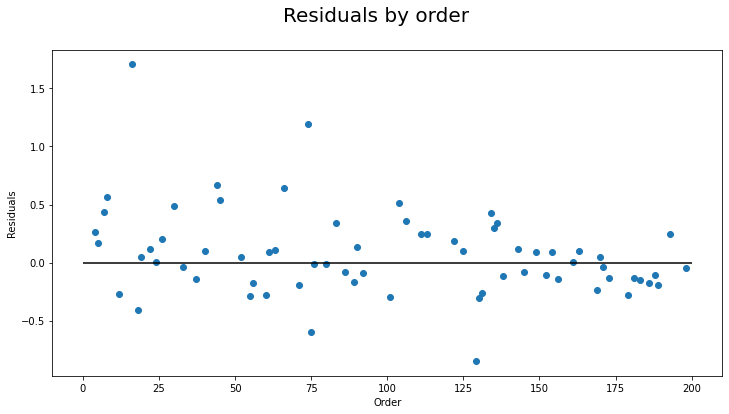

In [195]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(resid.index, resid.values)
plt.hlines(0, 0, 200, color="black")

fig.suptitle("Residuals by order", fontsize=20)
plt.xlabel("Order")
plt.ylabel("Residuals")
plt.show()

As we see, the points are scattered randomly. no tendancy to be found.

1.Durbin_Watson Test

The test of Durbin-Watson tests the null hypothesis that the residuals are not dependent (autocorrelated) on each other.

The test returns a value d between 0 and 4.

A value d = 2: No autocorrelation detected in the sample.

A value d < 2: indicate a positive autocorrelation.

A d > 2 value: indicate a negative autocorrelation.

In general, values of d ~ 2 indicate that there is no dependence (no autocorrelation) between the residuals.

In [196]:
from statsmodels.stats.stattools import durbin_watson

In [197]:
print(durbin_watson(resid))

[1.81015293]


1.ACF - Auto-Correlation Function plots

We want to see if the value of ACF is significant for each bar.

By calling the function, we indicate the level of significance that interests us (alpha = 0.05 in our case) and the critical zone is drawn on the graph (In blue).

Significant correlations lie outside this area.

Note: First bar is always at 1.

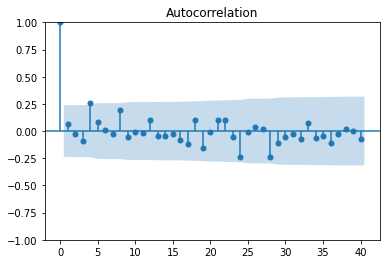

In [198]:
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(resid, lags=40, alpha=0.05)
acf.show()

We see that all the bars are inside the blue zone, except one, which is acceptable since Durbin_Watson returned a value very close to 2.

2-C. Homoscedasticity

This assumption indicates that the variance of the residuals must be similar for the values of the independent variables.

We can verify this by plotting the residuals against the predicted values.

To identify homo-dedasticity in the graph, the location of the points should be random and no trend should be visible, and the red regression line in the graph should be as flat as possible (not of an arch form).

Goldfeld-Quandt test:

He tests:

Null hypothesis H0: the error terms are homoscedastic
Alternative Hypothesis H1: The error terms are heteroscedastic.
Recall:

If P-value <= 0.05 ==> We reject the null hypothesis H0

If P-Value> 0.05 ==> The null hypothesis H0 is true


----Goldfeld-Quandt test ----
[('F statistic', 1.8786403206327875), ('p-value', 0.07034410207973114)]

----Residuals plots ----


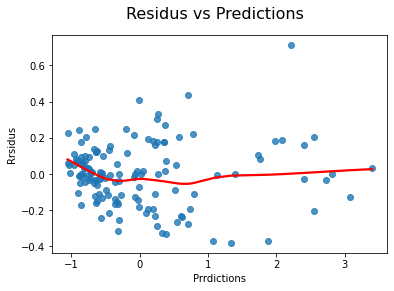

In [199]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip


def homoscedasticity_test(model):
    fitted_vals = model.predict()
    resids = model.resid

    sns.regplot(x=fitted_vals, y=resids, lowess=True,
                line_kws={'color': 'red'})
    plt.suptitle('Residus vs Predictions', fontsize=16)
    plt.xlabel('Prrdictions')
    plt.ylabel('Rrsidus')

    print('\n----Goldfeld-Quandt test ----')
    name = ['F statistic', 'p-value']
    test = sms.het_goldfeldquandt(model.resid, model.model.exog)
    print(lzip(name, test))
    print('\n----Residuals plots ----')


homoscedasticity_test(model)


Analysis:

P-Value test Goldfeld-Quandt > 0.05, so we accept H0 saying that the error terms are homoscedastic, which means that the residuals have a constant variance.

Also, in the plot, the points are scattered randomly, no tendancy to be found, and the line doesn't have the form of an arch

all the hypotheses are verified

Evaluation of the test via the comparison of y_pred and y_test

What we are looking for is that the errors should be as close as possible to the line, wich is the case in the plot below

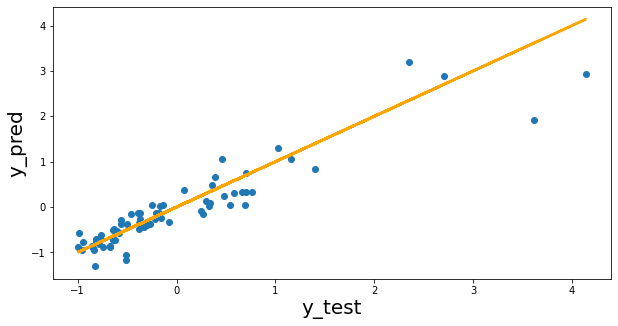

In [200]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.xlabel('y_test', fontsize=20)
plt.ylabel('y_pred', fontsize=20)

# Regression Line function
def f(x): 
    return x

# x values of line to plot
x = np.array(y_test)

# plot fit
plt.plot(x, f(x), lw=2.5, c="orange")


# Final Summary - Part 1
Coefficient of determination R²:

Recall:

If R² = 0: the dependent variable Y can not be predicted from the independent variable X

If R² = 1: the dependent variable Y can be predicted from the independent variable X

If 0 <R² <1: Indicates the percentage at which the dependent variable Y is predictable by X

In [201]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.8558800905758741


In [202]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     56.21
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           1.01e-48
Time:                        21:00:09   Log-Likelihood:                 46.514
No. Observations:                 137   AIC:                             8.971
Df Residuals:                      86   BIC:                             157.9
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
wheelbase                  0

59 variables used to have R²> 0.8, which is too much.

===================================================================================================

P-values of some variables appear to be greater than 0.05, meaning they are statistically insignificant.

==== The 2nd warning says: ===

 The smallest eigenvalue is 2.4e-30. This may indicate that there are strong problems of multicollinearity or
 that the design matrix is singular.

Violation of hypothesis of multicollinearity. There are correlated variables between them which should not exist

Can we do better?

Yes, by using RFE

## RFE

In the section of Exploring Data, we have identified the relevant independent variables that are correlated with the independent variable Price, and which are not correlated with each other (ie no multi-collinearity), and we said that we need to keep them, and igon the rest.

To do that, we will use a mixed approach to find the relevant features:

 1.Identify these variables using RFE (Recursive Feature Elimination)

 2.Manual approach to find the right fit
The use of RFE gives us an automated way to select important attributes that can influence the dependent variable (i.e Price).

We will use a mixed approach here and initially, we will simply use the functionalities returned by RFE as a starting model.

In [203]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [204]:
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [205]:
rfe = RFE(regression, step = 10)
rfe = rfe.fit(X_train,y_train)

Extract important variables

The RFE() method returns a "support_" array of variables considered important:

If support_ == True: Important variable

If support_ == False: Not important variable

In [206]:
for i in range(len(X_train.columns)):
    print(X_train.columns[i], "\t", rfe.support_[i])

wheelbase 	 True
boreratio 	 False
horsepower 	 True
citympg 	 False
symboling_-1 	 False
symboling_0 	 False
symboling_1 	 False
symboling_2 	 False
symboling_3 	 True
CompanyName_audi 	 False
CompanyName_bmw 	 True
CompanyName_buick 	 True
CompanyName_chevrolet 	 True
CompanyName_dodge 	 True
CompanyName_honda 	 True
CompanyName_isuzu 	 True
CompanyName_jaguar 	 True
CompanyName_mazda 	 True
CompanyName_mercury 	 False
CompanyName_mitsubishi 	 True
CompanyName_nissan 	 True
CompanyName_peugeot 	 False
CompanyName_plymouth 	 True
CompanyName_porsche 	 True
CompanyName_renault 	 False
CompanyName_saab 	 False
CompanyName_subaru 	 True
CompanyName_toyota 	 True
CompanyName_volkswagen 	 False
CompanyName_volvo 	 False
fueltype_gas 	 False
aspiration_turbo 	 False
doornumber_two 	 False
carbody_hardtop 	 True
carbody_hatchback 	 True
carbody_sedan 	 True
carbody_wagon 	 True
drivewheel_fwd 	 False
drivewheel_rwd 	 False
enginelocation_rear 	 True
enginetype_dohcv 	 False
enginetype_l 	 Fa

The columns selected by RFE

In [207]:
col = X_train.columns[rfe.support_]
for i in col:
    print(i)


wheelbase
horsepower
symboling_3
CompanyName_bmw
CompanyName_buick
CompanyName_chevrolet
CompanyName_dodge
CompanyName_honda
CompanyName_isuzu
CompanyName_jaguar
CompanyName_mazda
CompanyName_mitsubishi
CompanyName_nissan
CompanyName_plymouth
CompanyName_porsche
CompanyName_subaru
CompanyName_toyota
carbody_hardtop
carbody_hatchback
carbody_sedan
carbody_wagon
enginelocation_rear
enginetype_ohc
enginetype_ohcf
cylindernumber_five
cylindernumber_four
cylindernumber_six
cylindernumber_twelve
fuelsystem_spfi


Using statsmodel package, for detailed statistics

Here is our Dataset for learning, after RFE

In [208]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

,wheelbase,horsepower,symboling_3,CompanyName_bmw,CompanyName_buick,CompanyName_chevrolet,CompanyName_dodge,CompanyName_honda,CompanyName_isuzu,CompanyName_jaguar,...,carbody_sedan,carbody_wagon,enginelocation_rear,enginetype_ohc,enginetype_ohcf,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_twelve,fuelsystem_spfi
155,-0.534054,-1.103524,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
97,-0.723234,-0.921031,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
54,-0.943944,-0.947101,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
184,-0.281814,-1.364229,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
51,-0.943944,-0.947101,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [209]:
import statsmodels.api as sm


def color_code_vif_values(val):
    """
    Take a scalar and return a string with the property css 'color: red' for 10, black otherwise.
    """
    if val > 10:
        color = 'red'
    elif val > 5 and val <= 10:
        color = 'blue'
    elif val > 0 and val <= 5:
        color = 'darkgreen'
    else:
        color = 'black'
    return 'color: %s' % color


def drop_col(dataframe, col_to_drop):
    dataframe.drop([col_to_drop], axis=1, inplace=True)
    return dataframe


def display_vif(x):
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif = pd.DataFrame()
    X = x
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(
        X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.set_index("Features")
    vif = vif.sort_values(by="VIF", ascending=False)
    df = pd.DataFrame(vif.VIF).style.applymap(color_code_vif_values)
    display(df)


model_count = 0


def statsmodel_summary(y_var, x_var):
    global model_count
    model_count = model_count + 1
    text = "*****MODEL - " + str(model_count)
    print(text)

    x_var_const = sm.add_constant(x_var)  # adding constant
    model = sm.OLS(y_var, x_var_const).fit()  # calculating the fit
    print(model.summary())  # print summary for analysis
    display_vif(x_var_const.drop(['const'], axis=1))
    return x_var_const, model


## I. Check the multicollinearity between the variables selected by RFE

To do that, we base ourselves on 2 things:

1.P-Value:

P-Value <= **0.05** means that this particular independent variable greatly improves the fit of the model

P-value > **0.05** no improvement

2.VIF (Variance Inflation Factor):

VIF > **5**, there is an indication that multicollinearity may be present, but not enough to worry.

VIF > **10**, there is certainly a multicollinearity among the variables.

In [210]:
model = statsmodel_summary(y_train, X_train_rfe)

*****MODEL - 1
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     99.89
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           1.01e-64
Time:                        21:00:10   Log-Likelihood:                 28.105
No. Observations:                 137   AIC:                           -0.2094
Df Residuals:                     109   BIC:                             81.55
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const        

,VIF
Features,
CompanyName_porsche,inf
enginetype_ohcf,inf
enginelocation_rear,inf
CompanyName_subaru,inf
cylindernumber_four,23.480000
carbody_sedan,15.940000
carbody_hatchback,9.830000
enginetype_ohc,9.820000
cylindernumber_six,5.810000


P-value analysis: P-value of carbody_sedan > 0.05. We must delete it.



In [211]:
X_train_rfe = X_train_rfe.drop(["carbody_sedan"], axis = 1)
X_train_rfe.head()

,wheelbase,horsepower,symboling_3,CompanyName_bmw,CompanyName_buick,CompanyName_chevrolet,CompanyName_dodge,CompanyName_honda,CompanyName_isuzu,CompanyName_jaguar,...,carbody_hatchback,carbody_wagon,enginelocation_rear,enginetype_ohc,enginetype_ohcf,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_twelve,fuelsystem_spfi
155,-0.534054,-1.103524,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
97,-0.723234,-0.921031,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
54,-0.943944,-0.947101,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
184,-0.281814,-1.364229,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
51,-0.943944,-0.947101,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [212]:
model = statsmodel_summary(y_train, X_train_rfe)

*****MODEL - 2
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     85.58
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           3.57e-61
Time:                        21:00:10   Log-Likelihood:                 14.892
No. Observations:                 137   AIC:                             24.22
Df Residuals:                     110   BIC:                             103.1
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const        

,VIF
Features,
CompanyName_porsche,inf
enginetype_ohcf,inf
enginelocation_rear,inf
CompanyName_subaru,inf
enginetype_ohc,9.680000
cylindernumber_four,9.360000
horsepower,3.860000
cylindernumber_six,3.340000
wheelbase,3.010000


In [213]:
X_train_rfe = X_train_rfe.drop(["symboling_3"], axis=1)
X_train_rfe = X_train_rfe.drop(["CompanyName_chevrolet"], axis=1)
X_train_rfe = X_train_rfe.drop(["CompanyName_isuzu"], axis=1)
X_train_rfe = X_train_rfe.drop(["carbody_hatchback"], axis=1)
X_train_rfe = X_train_rfe.drop(["carbody_wagon"], axis=1)
X_train_rfe = X_train_rfe.drop(["enginetype_ohc"], axis=1)
X_train_rfe = X_train_rfe.drop(["cylindernumber_six"], axis=1)
X_train_rfe = X_train_rfe.drop(["cylindernumber_twelve"], axis=1)
X_train_rfe = X_train_rfe.drop(["fuelsystem_spfi"], axis=1)

X_train_rfe.head()


,wheelbase,horsepower,CompanyName_bmw,CompanyName_buick,CompanyName_dodge,CompanyName_honda,CompanyName_jaguar,CompanyName_mazda,CompanyName_mitsubishi,CompanyName_nissan,CompanyName_plymouth,CompanyName_porsche,CompanyName_subaru,CompanyName_toyota,carbody_hardtop,enginelocation_rear,enginetype_ohcf,cylindernumber_five,cylindernumber_four
155,-0.534054,-1.103524,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
97,-0.723234,-0.921031,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
54,-0.943944,-0.947101,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
184,-0.281814,-1.364229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
51,-0.943944,-0.947101,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [214]:
model = statsmodel_summary(y_train, X_train_rfe)

*****MODEL - 3
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     120.0
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           2.01e-66
Time:                        21:00:43   Log-Likelihood:                 4.1552
No. Observations:                 137   AIC:                             27.69
Df Residuals:                     119   BIC:                             80.25
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const        

,VIF
Features,
enginetype_ohcf,inf
enginelocation_rear,inf
CompanyName_subaru,inf
CompanyName_porsche,inf
cylindernumber_four,3.350000
horsepower,2.180000
wheelbase,1.950000
CompanyName_buick,1.820000
cylindernumber_five,1.640000


In [236]:
X_train_rfe = X_train_rfe.drop(["CompanyName_mazda"], axis=1)
X_train_rfe = X_train_rfe.drop(["carbody_hardtop"], axis=1)
X_train_rfe = X_train_rfe.drop(["CompanyName_honda"], axis=1)

X_train_rfe.head()


,wheelbase,horsepower,CompanyName_bmw,CompanyName_buick,CompanyName_dodge,CompanyName_jaguar,CompanyName_mitsubishi,CompanyName_nissan,CompanyName_plymouth,CompanyName_porsche,CompanyName_subaru,CompanyName_toyota,enginelocation_rear,enginetype_ohcf,cylindernumber_five,cylindernumber_four
155,-0.534054,-1.103524,0,0,0,0,0,0,0,0,0,1,0,0,0,1
97,-0.723234,-0.921031,0,0,0,0,0,1,0,0,0,0,0,0,0,1
54,-0.943944,-0.947101,0,0,0,0,0,0,0,0,0,0,0,0,0,1
184,-0.281814,-1.364229,0,0,0,0,0,0,0,0,0,0,0,0,0,1
51,-0.943944,-0.947101,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [237]:
model = statsmodel_summary(y_train, X_train_rfe)

*****MODEL - 5
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     136.0
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           2.51e-67
Time:                        21:11:26   Log-Likelihood:                -1.9153
No. Observations:                 137   AIC:                             33.83
Df Residuals:                     122   BIC:                             77.63
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const        

,VIF
Features,
CompanyName_porsche,inf
CompanyName_subaru,inf
enginelocation_rear,inf
enginetype_ohcf,inf
cylindernumber_four,2.340000
horsepower,2.180000
CompanyName_buick,1.780000
wheelbase,1.710000
cylindernumber_five,1.630000


All P-Values are less than 0.05, and all VIF values are less than 5.

Turning now to the prediction and evaluation of our model

# Prediction and Evaluation
## 1. Prediction

Creation of X_test_new by keeping only the relevant variables found by RFE.



In [238]:
#Array containing names of important variables
final_features = list(X_train_rfe.columns)

#Filter the test dataset
X_test_new = X_test.filter(final_features)

X_test_new.head()

,wheelbase,horsepower,CompanyName_bmw,CompanyName_buick,CompanyName_dodge,CompanyName_jaguar,CompanyName_mitsubishi,CompanyName_nissan,CompanyName_plymouth,CompanyName_porsche,CompanyName_subaru,CompanyName_toyota,enginelocation_rear,enginetype_ohcf,cylindernumber_five,cylindernumber_four
52,-0.959261,-0.858916,0,0,0,0,0,0,0,0,0,0,0,0,0,1
181,1.232366,1.258823,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0.328801,0.151823,0,0,0,0,0,0,0,0,0,0,0,0,1,0
18,-1.862826,-1.340220,0,0,0,0,0,0,0,0,0,0,0,0,0,0
188,-0.151819,-0.088829,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Let's use our model now to make predictions.



In [239]:
# Making predictions
model = sm.OLS(y_train, X_train_rfe).fit()

y_pred = model.predict(X_test_new)


## 2. Evaluation
Residual analysis of the mode

In [240]:
resid = y_test - y_pred.to_frame("price")

2-A. Independence of errors:

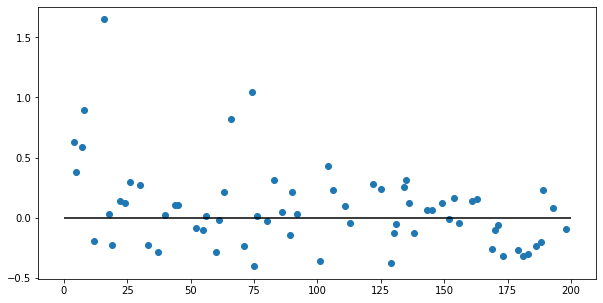

In [241]:
plt.figure(figsize=(10,5))
plt.scatter(resid.index, resid.values)
plt.hlines(0,0,200, color = "black")

As we see, the points are scattered at random. no trend.

2. Durbin_Watson Test

In [242]:
print(durbin_watson(resid))


[1.84447283]


3. ACF - Auto-Correlation Function plots



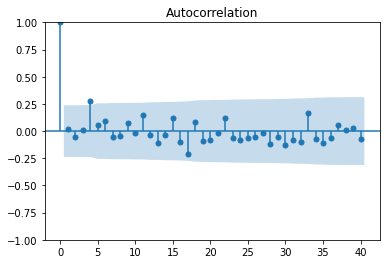

In [243]:
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(resid, lags=40 , alpha=0.05)
acf.show()

We see that all the bars are inside the blue zone, except one, which is acceptable since Durbin_Watson has returned a value very close to 2.0

2-B. Homoscedasticity


----Goldfeld-Quandt test ----
[('F statistic', 1.5788056643227413), ('p-value', 0.04719484294007098)]

----Residuals plots ----


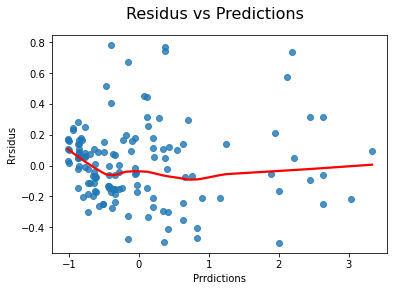

In [244]:
homoscedasticity_test(model)


Analysis:

P-Value of Goldfeld-Quandt Test > 0.05, so we accept H0 saying that the error terms are homoscedastic, which means that the residuals have a constant variance.

Also, in the plot, the points are scattered randomly, no tendancy to be found, and the line doesn't have the form of an arc

2-C. Normality of the error distribution



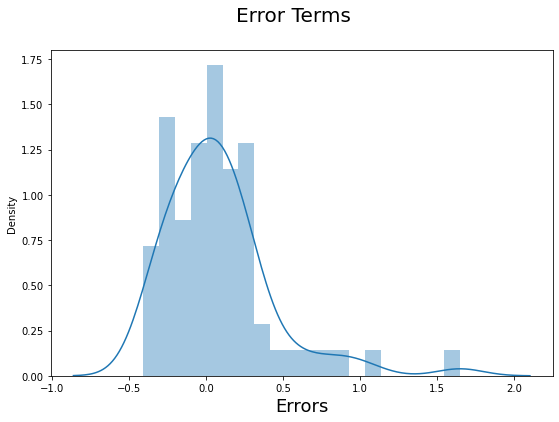

In [245]:
fig = plt.figure(figsize=(9,6))
sns.distplot(resid, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)
plt.show()

Analysis: The error terms are a little bit asymmetric.



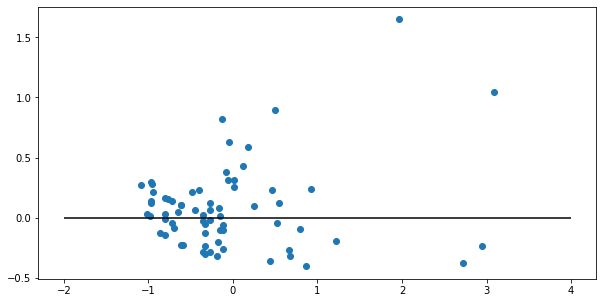

In [246]:
plt.figure(figsize=(10,5))
plt.scatter(y_pred, resid)
plt.hlines(0, -2, 4, color = "black")


Analysis: Data points are a bit more on one side than the other

Anderson-Darling Test and Q-Q Plot



Anderson-Darling test 
Statistic: 1.2695, Critical value of 5%: 0.7660


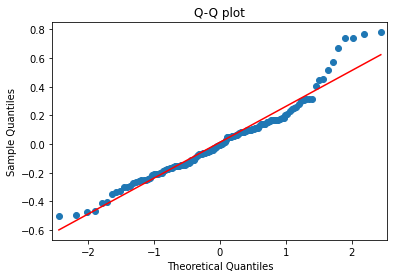

In [247]:
normality_of_residuals_test(model)


The blue trace slightly take form of an arc, but not aggressively

the test rejects H0 that the data follow a normal distribution (stats > critical value of 5%)

Evaluation of the test via the comparison of y_pred and y_test

What we are looking for is that the errors should be as close as possible to the line

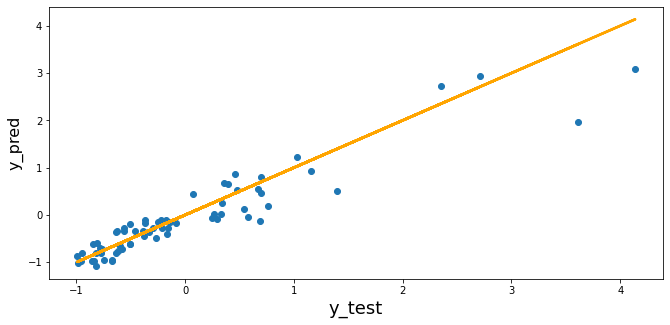

In [248]:
fig = plt.figure(figsize=(11, 5))
plt.scatter(y_test, y_pred)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

# Regression Line function


def f(x): return x


# x values of line to plot
x = np.array(y_test)

# plot fit
plt.plot(x, f(x), lw=2.5, c="orange")


## Final summary of the model
Coefficient of determination R².



In [249]:
from sklearn.metrics import r2_score 
r2_score(y_test, y_pred)

0.8717350097368088

What has changed with RFE?

1.R² decreased by 0.05 and remains above 0.8 which is good.

2.The value of the Durbin-watson test has increased, indicating more independence of errors.

3.The value of the Golden-Quandt test has increased sharply from 0.070 to 0.130, and the red line remains flat. (Much better homo-scedasticity)

4.No multicollinearity.


But, we see that the hypothesis of normality of errors is violated.

Actual data rarely includes normally distributed errors, and it may not be possible to adapt your data to a model whose errors do not violate the normality assumption.

It is usually best to focus on violations of other assumptions and / or on the influence of some Outliers (who may in any case be responsible for violations of normality).

So, if I have the choice between, violating the hypothesis of multicollinearity or the hypothesis of normality of the errors. I will choose normality because it is the least sensitive hypothesis among the others.

In [250]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              131.6
Date:                Fri, 26 Aug 2022   Prob (F-statistic):                    6.96e-67
Time:                        21:11:27   Log-Likelihood:                         -4.5802
No. Observations:                 137   AIC:                                      37.16
Df Residuals:                     123   BIC:                                      78.04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

All the P-Values are under 0.05. Also, the Previous Alert that we had about existence of Multi-colinearity is not there any more

Reduction of dimension

7 variables against 59 for R²> 0.8 !!! It's much better

Is it good ?

Still not 100% perfect, because of the existence of Outliers that strongly affect our model

Next step ?

Detect and treat Outliers (either delete them, or fix them if there are errors) and see if there are improvements.

Check my Other Kernel Regarding this Step